# Revisiting the Preprocessing of RTA Dataset
Post Optimum Solution Session

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import missingno as msno
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier
import joblib
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
import optuna
from sklearn.model_selection import StratifiedKFold

In [3]:
df = pd.read_csv("../Dataset/RTA Dataset.csv")

print(df.shape)


(12316, 32)


In [33]:
df.sample(5)

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
3364,19:03:00,Friday,Over 51,Male,Junior high school,Employee,2-5yr,Pick up upto 10Q,Owner,Unknown,...,Going straight,na,na,na,na,Self-employed,Normal,Not a Pedestrian,No priority to vehicle,Slight Injury
8521,0:40:00,Saturday,Under 18,Male,Junior high school,Employee,2-5yr,Public (13?45 seats),Owner,NaN,...,Going straight,Driver or rider,Male,18-30,3,Driver,Normal,Not a Pedestrian,Moving Backward,Serious Injury
8276,17:09:00,Wednesday,Unknown,Female,Junior high school,Employee,Below 1yr,Pick up upto 10Q,Owner,NaN,...,Going straight,Passenger,Female,31-50,3,Driver,Normal,Not a Pedestrian,No priority to vehicle,Serious Injury
3915,8:31:00,Monday,31-50,Male,Junior high school,Owner,Below 1yr,Pick up upto 10Q,Owner,Unknown,...,Going straight,Driver or rider,Male,31-50,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
2751,18:07:00,Tuesday,Unknown,Male,Junior high school,Employee,Above 10yr,Turbo,Owner,NaN,...,Getting off,Passenger,Female,31-50,3,Driver,Normal,Not a Pedestrian,Moving Backward,Slight Injury


In [4]:
# renaming columns
col_map={
    'Time': 'time',
    'Day_of_week': 'day_of_week',
    'Age_band_of_driver': 'driver_age',
    'Sex_of_driver': 'driver_sex',
    'Educational_level': 'educational_level',
    'Vehicle_driver_relation': 'vehicle_driver_relation',
    'Driving_experience': 'driving_experience',
    'Type_of_vehicle': 'vehicle_type',
    'Owner_of_vehicle': 'vehicle_owner',
    'Service_year_of_vehicle': 'service_year',
    'Defect_of_vehicle': 'vehicle_defect',
    'Area_accident_occured': 'accident_area',
    'Lanes_or_Medians': 'lanes',
    'Road_allignment': 'road_allignment',
    'Types_of_Junction': 'junction_type',
    'Road_surface_type': 'surface_type',
    'Road_surface_conditions': 'road_surface_conditions',
    'Light_conditions': 'light_condition',
    'Weather_conditions': 'weather_condition',
    'Type_of_collision': 'collision_type',
    'Number_of_vehicles_involved': 'vehicles_involved',
    'Number_of_casualties': 'casualties',
    'Vehicle_movement': 'vehicle_movement',
    'Casualty_class': 'casualty_class',
    'Sex_of_casualty': 'casualty_sex' , 
    'Age_band_of_casualty': 'casualty_age', 
    'Casualty_severity': 'casualty_severity',
    'Work_of_casuality': 'casualty_work', 
    'Fitness_of_casuality': 'casualty_fitness',
    'Pedestrian_movement': 'pedestrian_movement',
    'Cause_of_accident': 'accident_cause',
    'Accident_severity': 'accident_severity'
}
df.rename(columns=col_map, inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   time                     12316 non-null  object
 1   day_of_week              12316 non-null  object
 2   driver_age               12316 non-null  object
 3   driver_sex               12316 non-null  object
 4   educational_level        11575 non-null  object
 5   vehicle_driver_relation  11737 non-null  object
 6   driving_experience       11487 non-null  object
 7   vehicle_type             11366 non-null  object
 8   vehicle_owner            11834 non-null  object
 9   service_year             8388 non-null   object
 10  vehicle_defect           7889 non-null   object
 11  accident_area            12077 non-null  object
 12  lanes                    11931 non-null  object
 13  road_allignment          12174 non-null  object
 14  junction_type            11429 non-nul

In [5]:
# checking duplicates
df.duplicated().sum()

0

In [6]:
# checking constant features
[col for col in df if df[col].nunique()==1]

[]

In [7]:
# remove trailing spaces from categorical features (in our case from  single feature called "accident_area")
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.strip()

In [10]:
df['accident_area'].value_counts()

accident_area
Other                  3819
Office areas           3451
Residential areas      2060
Church areas           1060
Industrial areas        456
School areas            415
Recreational areas      328
Outside rural areas     218
Hospital areas          121
Rural village areas      64
Market areas             63
Unknown                  22
Name: count, dtype: int64

In [9]:
df["accident_area"] = df["accident_area"].replace("Rural village areasOffice areas", "Rural village areas")

### Extracting hour and minute from timestamp

In [11]:
# convert time column from object to datetime
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')

In [12]:

df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df.drop(['time'], axis=1, inplace=True)

In [13]:
df.drop(["minute"], axis=1, inplace=True)

## Missing Value Treatment 

In [14]:
# checking missing values
df.isnull().sum()

day_of_week                   0
driver_age                    0
driver_sex                    0
educational_level           741
vehicle_driver_relation     579
driving_experience          829
vehicle_type                950
vehicle_owner               482
service_year               3928
vehicle_defect             4427
accident_area               239
lanes                       385
road_allignment             142
junction_type               887
surface_type                172
road_surface_conditions       0
light_condition               0
weather_condition             0
collision_type              155
vehicles_involved             0
casualties                    0
vehicle_movement            308
casualty_class                0
casualty_sex                  0
casualty_age                  0
casualty_severity             0
casualty_work              3198
casualty_fitness           2635
pedestrian_movement           0
accident_cause                0
accident_severity             0
hour    

In [15]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [16]:
missing_values_table(df)

Your selected dataframe has 32 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
vehicle_defect,4427,35.9
service_year,3928,31.9
casualty_work,3198,26.0
casualty_fitness,2635,21.4
vehicle_type,950,7.7
junction_type,887,7.2
driving_experience,829,6.7
educational_level,741,6.0
vehicle_driver_relation,579,4.7
vehicle_owner,482,3.9


<Axes: >

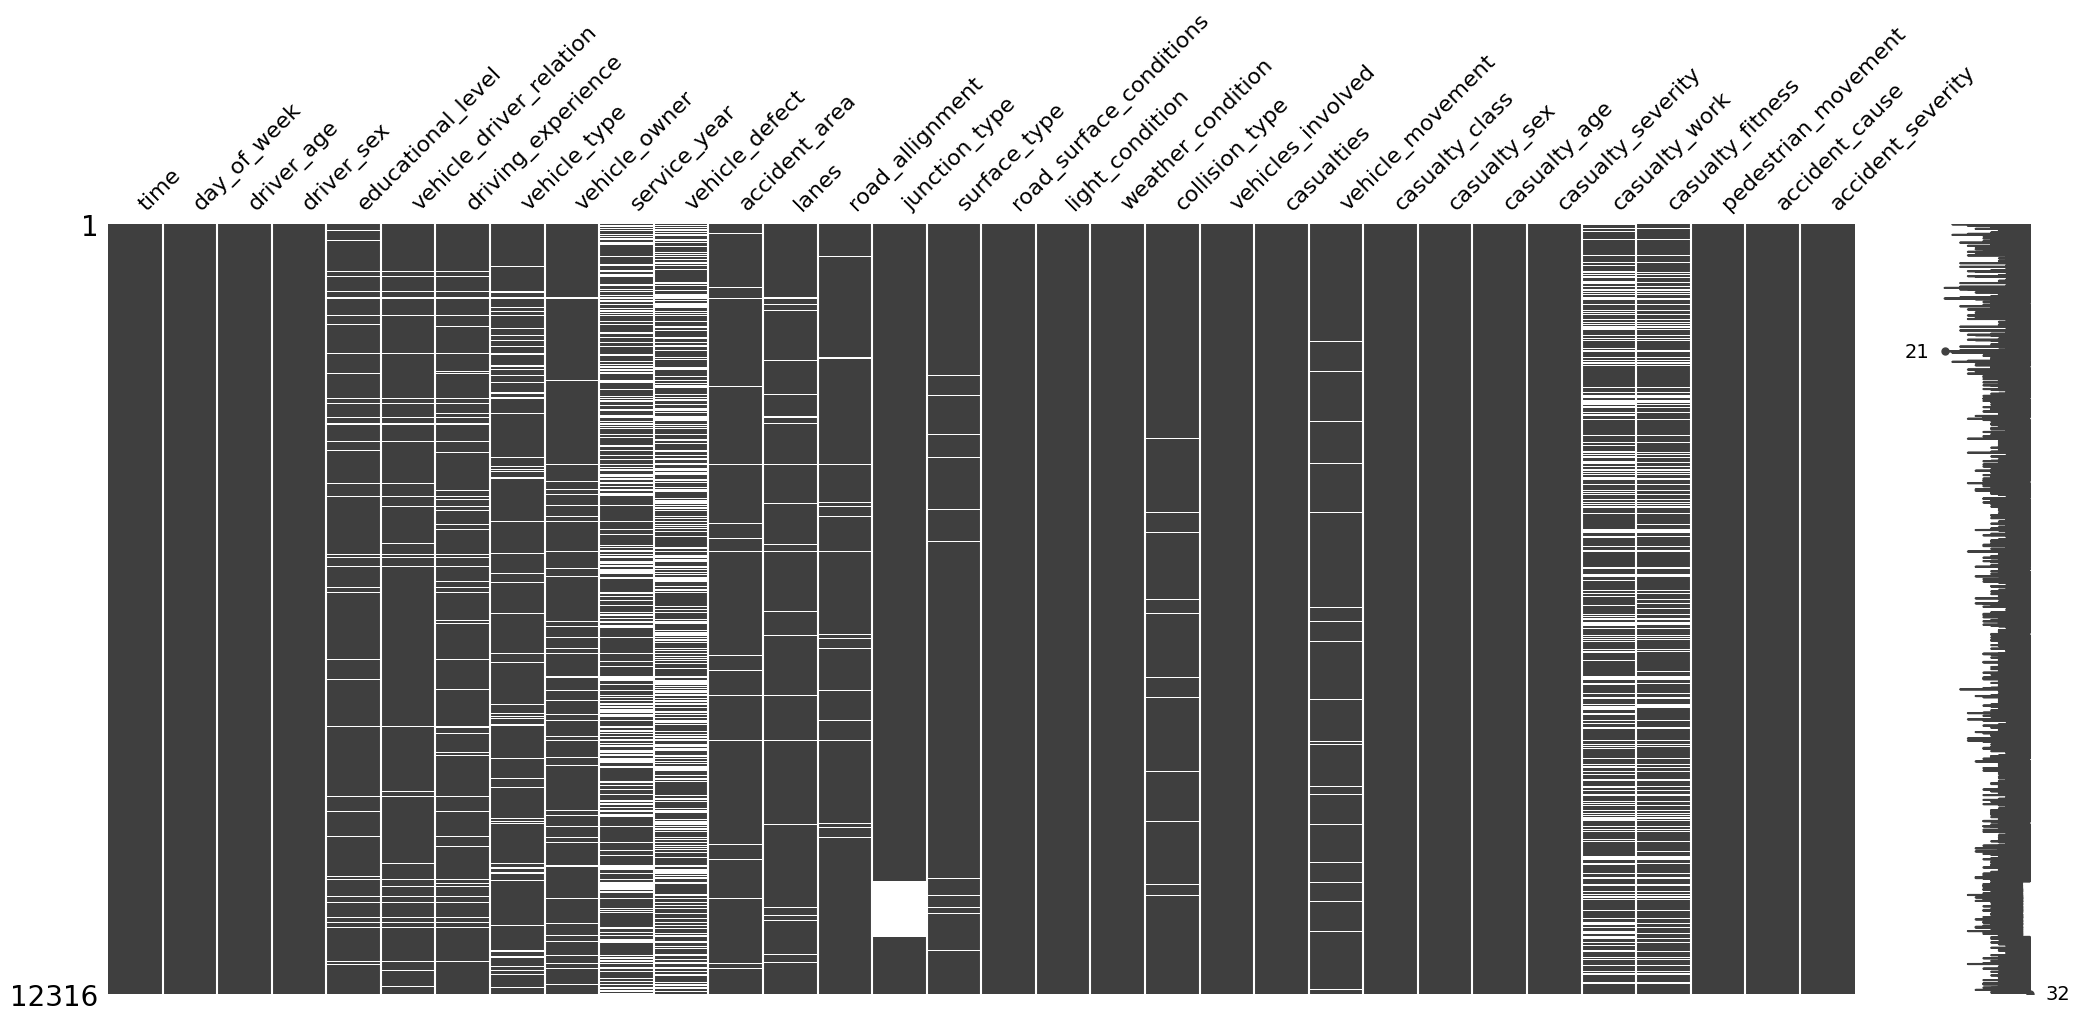

In [16]:
msno.matrix(df)

<Axes: >

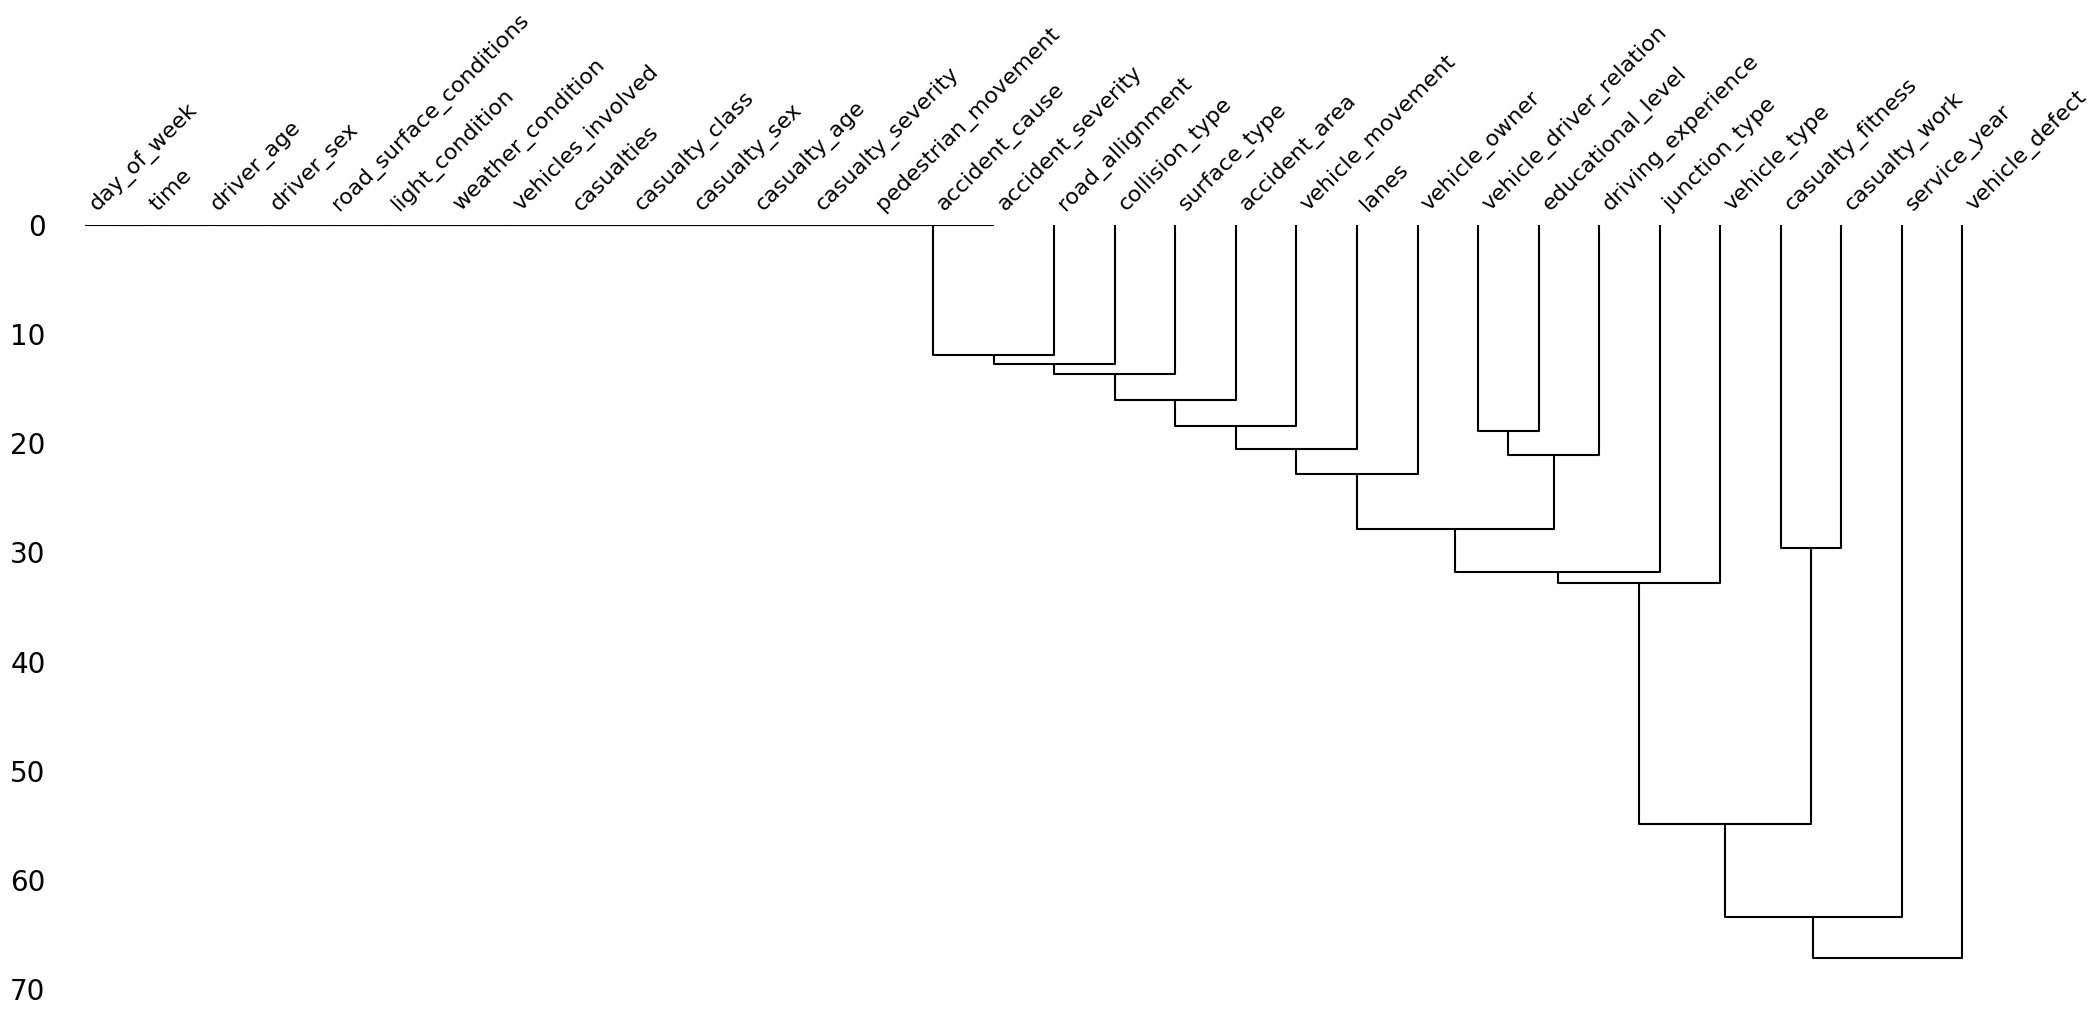

In [17]:
msno.dendrogram(df)

#### Dropping vehicle defect column

In [17]:
# dropping columns with more than 90% missing values
df.drop('vehicle_defect', axis=1, inplace=True)

### Impuation 

In [18]:
from sklearn.impute import SimpleImputer
df_imp = df.copy()
# Setting strategy to 'most frequent' to impute by the mode
mean_imputer = SimpleImputer(strategy='most_frequent')# strategy can also be mean or median 
df_imp.iloc[:,:] = mean_imputer.fit_transform(df_imp)

In [19]:
df_imp.isnull().sum()

day_of_week                0
driver_age                 0
driver_sex                 0
educational_level          0
vehicle_driver_relation    0
driving_experience         0
vehicle_type               0
vehicle_owner              0
service_year               0
accident_area              0
lanes                      0
road_allignment            0
junction_type              0
surface_type               0
road_surface_conditions    0
light_condition            0
weather_condition          0
collision_type             0
vehicles_involved          0
casualties                 0
vehicle_movement           0
casualty_class             0
casualty_sex               0
casualty_age               0
casualty_severity          0
casualty_work              0
casualty_fitness           0
pedestrian_movement        0
accident_cause             0
accident_severity          0
hour                       0
dtype: int64

## Into the MATRIX of Encoding 🥶

In [20]:
# rearranging columns
cols = ['hour', 'day_of_week', 'driver_age', 'driver_sex', 'educational_level',
       'vehicle_driver_relation', 'driving_experience', 'vehicle_type',
       'vehicle_owner', 'service_year', 'accident_area',
       'lanes', 'road_allignment', 'junction_type', 'surface_type',
       'road_surface_conditions', 'light_condition', 'weather_condition',
       'collision_type', 'vehicles_involved', 'casualties', 'vehicle_movement',
       'casualty_class', 'casualty_sex', 'casualty_age', 'casualty_severity',
       'casualty_work', 'casualty_fitness', 'pedestrian_movement',
       'accident_cause', 'accident_severity']
df_imp = df_imp[cols]

In [21]:
df_imp.nunique()

hour                       24
day_of_week                 7
driver_age                  5
driver_sex                  3
educational_level           7
vehicle_driver_relation     4
driving_experience          7
vehicle_type               17
vehicle_owner               4
service_year                6
accident_area              12
lanes                       7
road_allignment             9
junction_type               8
surface_type                5
road_surface_conditions     4
light_condition             4
weather_condition           9
collision_type             10
vehicles_involved           6
casualties                  8
vehicle_movement           13
casualty_class              4
casualty_sex                3
casualty_age                6
casualty_severity           4
casualty_work               7
casualty_fitness            5
pedestrian_movement         9
accident_cause             20
accident_severity           3
dtype: int64

In [22]:
df_imp["accident_cause"].value_counts()

accident_cause
No distancing                           2263
Changing lane to the right              1808
Changing lane to the left               1473
Driving carelessly                      1402
No priority to vehicle                  1207
Moving Backward                         1137
No priority to pedestrian                721
Other                                    456
Overtaking                               430
Driving under the influence of drugs     340
Driving to the left                      284
Getting off the vehicle improperly       197
Driving at high speed                    174
Overturning                              149
Turnover                                  78
Overspeed                                 61
Overloading                               59
Drunk driving                             27
Unknown                                   25
Improper parking                          25
Name: count, dtype: int64

### One Hot Encoding... 

In [23]:
def one_hot(df, columns_to_encode):
    """
    Perform One-Hot Encoding on selected columns in a DataFrame and keep other columns intact.

    Parameters:
    - df: pandas DataFrame
        The input DataFrame.
    - columns_to_encode: list of str
        A list of column names to one-hot encode.

    Returns:
    - encoded_df: pandas DataFrame
        The DataFrame with specified columns one-hot encoded and other columns preserved. by using a seperator "~" to seperate the column name and the value
    """
    # Perform one-hot encoding on the selected columns
    encoded_df = pd.get_dummies(df, columns=columns_to_encode, prefix=[f"{col}~" for col in columns_to_encode], dtype=int) # <<<< drawbacks of using gpt...
    
    return encoded_df

Exluding Numerical Features: "vechicles_involved" & "casualties"  and Also Ordinal Features : "day_of_week" & "accident_severiy" 

In [24]:
cols_ohe = ['driver_age', 'driver_sex', 'educational_level',
       'vehicle_driver_relation', 'driving_experience', 'vehicle_type',
       'vehicle_owner', 'service_year', 'accident_area',
       'lanes', 'road_allignment', 'junction_type', 'surface_type',
       'road_surface_conditions', 'light_condition', 'weather_condition',
       'collision_type', 'vehicle_movement',
       'casualty_class', 'casualty_sex', 'casualty_age', 'casualty_severity',
       'casualty_work', 'casualty_fitness', 'pedestrian_movement',
       'accident_cause']

df_ohe = one_hot(df_imp, cols_ohe)

In [25]:
# Ordinal Encoding for day_of_week
df_ohe['day_of_week'] = df_ohe['day_of_week'].map({'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5,"Friday":6,"Saturday":7})
# Ordinal Encoding for Accident_severity
df_ohe['accident_severity'] = df_ohe['accident_severity'].map({'Slight Injury': 1, 'Serious Injury': 2, 'Fatal injury': 3})

In [26]:
df_ohe.head()

,hour,day_of_week,vehicles_involved,casualties,accident_severity,driver_age~_18-30,driver_age~_31-50,driver_age~_Over 51,driver_age~_Under 18,driver_age~_Unknown,...,accident_cause~_No distancing,accident_cause~_No priority to pedestrian,accident_cause~_No priority to vehicle,accident_cause~_Other,accident_cause~_Overloading,accident_cause~_Overspeed,accident_cause~_Overtaking,accident_cause~_Overturning,accident_cause~_Turnover,accident_cause~_Unknown
0,17,2,2,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17,2,2,2,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,17,2,2,2,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,2,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,2,2,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Imbalanced Features 

In [27]:
def imbalanced_features(df):
    mod_imb=[] # moderately imbalanced
    hi_imb=[] # highly imbalanced

    for col in df.columns:
        try:
            if (df[col].value_counts()/df.shape[0]).max() > 0.9:
                hi_imb.append(col)
            elif (df[col].value_counts()/df.shape[0]).max() > 0.7 and col not in hi_imb:
                mod_imb.append(col)
        except Exception as e:
            print(f"Couldn't check \033[1m{col}\033[0m. ", e, "\n")

    print("="*20, "\033[1m Imbalanced features\033[0m", "="*20)
    print("No of moderately imbalanced features (75%+ data on a single class): ", len(mod_imb), "\n")
    print(mod_imb, "\n")
    print("No of highly imbalanced features (90%+ data on a single class): ", len(hi_imb), "\n")
    print(hi_imb)
imbalanced_features(df_ohe)

====================  Imbalanced features ====================
No of moderately imbalanced features (75%+ data on a single class):  39 

['accident_severity', 'driver_age~_Over 51', 'driver_age~_Unknown', 'educational_level~_Elementary school', 'vehicle_driver_relation~_Employee', 'vehicle_driver_relation~_Owner', 'driving_experience~_1-2yr', 'driving_experience~_2-5yr', 'driving_experience~_Above 10yr', 'driving_experience~_Below 1yr', 'vehicle_type~_Lorry (41?100Q)', 'vehicle_owner~_Owner', 'service_year~_2-5yrs', 'service_year~_5-10yrs', 'service_year~_Above 10yr', 'accident_area~_Office areas', 'accident_area~_Residential areas', 'lanes~_other', 'road_allignment~_Tangent road with flat terrain', 'junction_type~_Crossing', 'road_surface_conditions~_Dry', 'road_surface_conditions~_Wet or damp', 'light_condition~_Darkness - lights lit', 'light_condition~_Daylight', 'weather_condition~_Normal', 'weather_condition~_Raining', 'collision_type~_Collision with roadside objects', 'collision_

Ofcourse it will be biased as ONE HOT ENCODING is DONE on Many categorical features

In [28]:
# Splitting the data for SMOTE-Tomek
X = df_ohe.drop('accident_severity', axis=1)
y = df_ohe['accident_severity']

In [29]:
print("Class distribution before resampling:\n", Counter(y))

Class distribution before resampling:
 Counter({1: 10415, 2: 1743, 3: 158})


In [30]:
# Implementing SMOTE-Tomek technique
smote_tomek = SMOTETomek(random_state=42)
X, y = smote_tomek.fit_resample(X, y)

In [31]:
counter = Counter(y)
for k,v in counter.items():
    per = 100*v/len(y)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

Class= 1, n=10396 (33.31%)
Class= 2, n=10398 (33.32%)
Class= 3, n=10413 (33.37%)


In [32]:
df = pd.concat([X, y], axis=1)
print("Upsampled data shape: ", df.shape)

Upsampled data shape:  (31207, 197)


In [90]:
df.sample()

,hour,day_of_week,vehicles_involved,casualties,driver_age~_18-30,driver_age~_31-50,driver_age~_Over 51,driver_age~_Under 18,driver_age~_Unknown,driver_sex~_Female,...,accident_cause~_No priority to pedestrian,accident_cause~_No priority to vehicle,accident_cause~_Other,accident_cause~_Overloading,accident_cause~_Overspeed,accident_cause~_Overtaking,accident_cause~_Overturning,accident_cause~_Turnover,accident_cause~_Unknown,accident_severity
22709,20,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


## Model Training 

In [33]:
# selecting a good baseline model using cross validation

models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('LOG', GaussianNB()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))

In [34]:
names = []
results = []
for name, model in models:
    fold = KFold(n_splits=10)
    score = cross_val_score(model, X, y, cv=fold, scoring='f1_macro')
    names.append(name)
    results.append(score)



In [78]:
plotdict = dict(zip(names, results))

for k,v in plotdict.items():
    print(f"{k}: {round(v.mean(),5)}")

KNN: nan
LOG: 0.39101
DTC: 0.50202
RFC: 0.63509


In [35]:
df.sample()

,hour,day_of_week,vehicles_involved,casualties,driver_age~_18-30,driver_age~_31-50,driver_age~_Over 51,driver_age~_Under 18,driver_age~_Unknown,driver_sex~_Female,...,accident_cause~_No priority to pedestrian,accident_cause~_No priority to vehicle,accident_cause~_Other,accident_cause~_Overloading,accident_cause~_Overspeed,accident_cause~_Overtaking,accident_cause~_Overturning,accident_cause~_Turnover,accident_cause~_Unknown,accident_severity
8362,10,3,2,2,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [47]:
model = RandomForestClassifier()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(21844, 196) (9363, 196) (21844,) (9363,)


In [49]:
model.fit(X_train, y_train) # training the model

RandomForestClassifier()

In [50]:
# predicting
y_pred = model.predict(X_test)

In [51]:
score = f1_score(y_test, y_pred, average='weighted')
print("f1_score: ", score)

f1_score:  0.9465847335623994


In [52]:
# getting feature importance
model.feature_importances_

array([6.12977511e-02, 4.35642451e-02, 3.92526432e-02, 5.26823330e-02,
       1.43693174e-02, 1.37300850e-02, 7.31831587e-03, 3.87788787e-03,
       1.18829034e-02, 1.93285580e-03, 4.94196829e-03, 4.65474514e-04,
       1.19146601e-03, 9.99825885e-03, 4.90984989e-03, 1.42785379e-04,
       1.61083985e-02, 3.30043944e-04, 6.66280372e-04, 1.28441298e-02,
       3.40074321e-04, 7.52089073e-03, 4.45216700e-05, 9.89476238e-03,
       1.12939969e-02, 1.61871025e-02, 1.10139178e-02, 8.41045955e-03,
       3.30247833e-04, 1.18211283e-04, 1.60079837e-02, 7.73257655e-05,
       6.63730136e-05, 1.49305141e-03, 2.08866535e-03, 1.06434541e-02,
       5.14987744e-04, 6.40888844e-03, 3.25637161e-03, 2.84610368e-03,
       2.10906139e-03, 1.62133072e-03, 2.31608113e-04, 3.36051038e-04,
       3.13534101e-03, 9.24618220e-04, 1.23817943e-04, 4.21577298e-03,
       7.76761298e-04, 5.49584496e-05, 9.02522768e-03, 3.69669759e-03,
       7.53430006e-03, 5.62104269e-03, 6.69990170e-03, 8.67175860e-04,
      

In [53]:
df_important = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_})

In [54]:
df_important.sort_values('importance', ascending=False)

,feature,importance
0,hour,0.061298
3,casualties,0.052682
1,day_of_week,0.043564
2,vehicles_involved,0.039253
105,light_condition~_Daylight,0.019436
...,...,...
131,vehicle_movement~_Parked,0.000025
171,"pedestrian_movement~_In carriageway, statioNot...",0.000015
107,weather_condition~_Fog or mist,0.000013
175,pedestrian_movement~_Walking along in carriage...,0.000007


### The MATRIX OF ENCODING DECODING 

In [55]:
# we have df_importance, now we have to merger our ohe encoded columns with name "actual_feature_name~_class_name" to get the actual feature name
# while merging the columns in df_important into their respective actual names we need to add the importances of all the columns with same actual name
# for example: "driver_age~_21-25" and "driver_age~_26-30" will be merged into "driver_age" with importance of 0.1+0.2 = 0.3
# how to do the above task?
# 1. get all the actual feature names
# 2. iterate over the actual feature names
# 3. for each actual feature name, get all the columns with that name
# 4. for each column, get the importance and add it to the importance of the actual feature name
# 5. create a new dataframe with actual feature names and their importances
#1
actual_features = []
for col in df_important['feature']:
    actual_features.append(col.split('~')[0])
actual_features = list(set(actual_features))
#2
feature_importance = []
for feature in actual_features:
    #3
    cols = [col for col in df_important['feature'] if col.startswith(feature)]
    #4
    importance = 0
    for col in cols:
        importance += df_important[df_important['feature']==col]['importance'].values[0]
    #5
    feature_importance.append([feature, importance])
    
# creating a new dataframe with actual feature names and their importances
df_feature_importance = pd.DataFrame(feature_importance, columns=['feature', 'importance'])
df_feature_importance.sort_values('importance', ascending=False, inplace=True)
df_feature_importance

,feature,importance
21,accident_cause,0.063883
1,hour,0.061298
10,driving_experience,0.057249
0,accident_area,0.054482
3,casualties,0.052682
9,vehicle_type,0.051885
28,driver_age,0.051179
14,lanes,0.050029
7,day_of_week,0.043564
29,junction_type,0.042406


In [56]:
df_feature_importance.shape

(30, 2)

<Axes: xlabel='importance', ylabel='feature'>

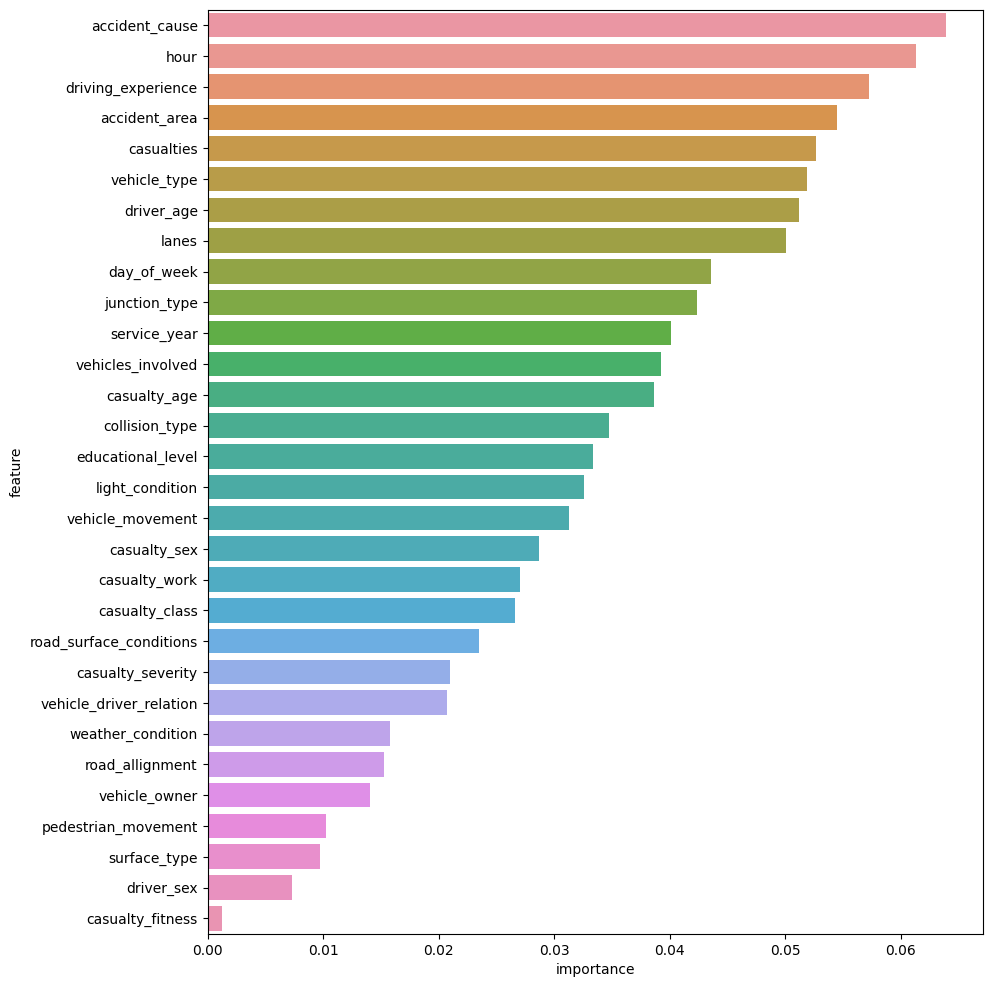

In [57]:
plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='feature', data=df_feature_importance)

In [59]:
# select top 15 features
top_features = df_feature_importance['feature'][:14].values
top_features

array(['accident_cause', 'hour', 'driving_experience', 'accident_area',
       'casualties', 'vehicle_type', 'driver_age', 'lanes', 'day_of_week',
       'junction_type', 'service_year', 'vehicles_involved',
       'casualty_age', 'collision_type'], dtype=object)

We have successfully selected top 14 features from our dataset 

We need to train the model on these 14 features!!!! so the following setps !

In [60]:
df.shape

(31207, 197)

In [61]:
cat_cols = ['accident_cause', 'driving_experience', 'lanes',
       'accident_area', 'driver_age', 'vehicle_type', 'junction_type',
       'service_year', 'casualty_age', 'collision_type']
df_new = pd.DataFrame()
for col in df.columns:
       for cols in cat_cols:
              if col.startswith(cols):
                     df_new[col] = df[col]
                     
remaining_cols = ['hour','casualties','day_of_week','vehicles_involved',"accident_severity"]
df_new = pd.concat([df_new, df[remaining_cols]], axis=1)

In [62]:
df_new.shape

(31207, 103)

In [64]:
df_new.to_csv("../Dataset/RTA_top14_enc.csv", index=False)

### Training on Top 15... Random Forest Classifier()

In [65]:
y = df_new['accident_severity']
X_top15 = df_new.drop('accident_severity', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_top15, y, test_size=0.3, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(21844, 102) (9363, 102) (21844,) (9363,)


In [130]:
# we want to find the best hyperparameters for our model using optuna library and StratifiedKFold cross validation technique
# Creating Objective Function for Optuna....
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    # Build Model 
    model = RandomForestClassifier(**params)
    # Train Model
    model.fit(X_train, y_train)
    # Evaluate Model
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return f1   

In [131]:
# Create an Optuna study object
study = optuna.create_study(direction='maximize')
# Run the optimization
study.optimize(objective, n_trials=100)
# Get the best hyperparameters
best_params = study.best_params
best_f1_score = study.best_value


[I 2023-09-13 19:04:49,648] A new study created in memory with name: no-name-3bf64e22-81bb-41c4-9e33-8d03d4b905ea
[I 2023-09-13 19:04:53,503] Trial 0 finished with value: 0.7410653082773021 and parameters: {'n_estimators': 407, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7410653082773021.
[I 2023-09-13 19:04:56,719] Trial 1 finished with value: 0.8232822918770265 and parameters: {'n_estimators': 224, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8232822918770265.
[I 2023-09-13 19:04:58,350] Trial 2 finished with value: 0.6823031648772931 and parameters: {'n_estimators': 220, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8232822918770265.
[I 2023-09-13 19:05:00,534] Trial 3 finished with value: 0.8631244732199307 and parameters: {'n_estimators': 126, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 3 with value: 0

{'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 90 with value: 0.872532268505002.

Tunning Hyperparameters .... Need to read parameter documentation of the Model!

new_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
    }

In [132]:
def objective(trial):
    new_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
    }
    # Build Model 
    model = RandomForestClassifier(**new_params)
    # Train Model
    model.fit(X_train, y_train)
    # Evaluate Model
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return f1   

In [133]:
# Create an Optuna study object
study = optuna.create_study(direction='maximize')
# Run the optimization
study.optimize(objective, n_trials=100)
# Get the best hyperparameters
best_params = study.best_params
best_f1_score = study.best_value

[I 2023-09-13 19:20:30,679] A new study created in memory with name: no-name-1e8ca320-865e-4c21-b87e-b4871a6f7c31
[I 2023-09-13 19:20:35,072] Trial 0 finished with value: 0.9247889371149141 and parameters: {'n_estimators': 165, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9247889371149141.
[I 2023-09-13 19:20:49,068] Trial 1 finished with value: 0.9019287985110724 and parameters: {'n_estimators': 685, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.9247889371149141.
[I 2023-09-13 19:20:54,045] Trial 2 finished with value: 0.9178733401458063 and parameters: {'n_estimators': 201, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.9247889371149141.
[I 2023-09-13 19:21:12,401] Trial 3 finished with value: 0.9139493436684897 and parameters: {'n_estimators': 826, 'max_depth': 45, 'min_samples_split': 10, 'min_samples_leaf': 15}. Best is trial 0 with v

In [134]:
print("Best F1 Score: ", best_f1_score)
print("Best Hyperparameters: ", best_params)

Best F1 Score:  0.9467985583165549
Best Hyperparameters:  {'n_estimators': 461, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 1}


⭐⭐⭐⭐⭐⭐🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥⭐⭐⭐⭐⭐⭐

### Save the Model using joblib

In [66]:
# Create the Random Forest classifier with the best hyperparameters
model = RandomForestClassifier(
    n_estimators=461,
    max_depth=41,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=8
)

# Train the classifier on the entire dataset
model.fit(X_train, y_train)

#Making predictions
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)
# Save the model using joblib
joblib.dump(model, 'random_forest_14.joblib')

0.9382160096651067


['random_forest_14.joblib']

## We can load the model using `joblib.load()` and make predictions on new data.

In [68]:
p = [i for i in X_train.columns]
print(len(p))

102
